Per prima cosa importiamo le librerie necessarie e definiamo qualche funzione utile




In [ ]:
try:
    import ice
except ModuleNotFoundError:
    import sys

    if "google.colab" in sys.modules:
        !python -m pip install -qqq --upgrade -- uv && python -m uv pip install --system --quiet -- https://github.com/baggiponte/aiss-2024.git
    else:
        raise

from google.colab import output
output.enable_custom_widget_manager()

Importiamo le immagini e organizziamole in cartelle con la funzione "load_animals_dataset(...)"

In [ ]:
from ice.animals import load_animals_data, define_my_zoo

!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals

data_folder = "zoo"

load_animals_data(data_folder)

Scegliamo quali animali utilizzare da qui in poi e creiamo lo "zoo" personalizzato

In [ ]:
# Tutti gli animali (richiede molto tempo)
# useful_animals = os.listdir(data_folder)

# Animali scelti
# useful_animals = ['cat', 'dog']
useful_animals = [
    "cat",
    "dog",
    "mouse",
    "hamster",
    "leopard",
    "lion",
    "mouse",
    "tiger",
    "wolf",
]


my_zoo = "my_zoo"
files, labels, names = define_my_zoo(useful_animals, my_zoo, data_folder)

Ora che abbiamo importato e preparato tutte le immagini, come possiamo renderle "digeribili" da un modello di machine learning?

Utilizziamo un modello di "**embedding**" per convertire il formato delle immagini a un formato numerico

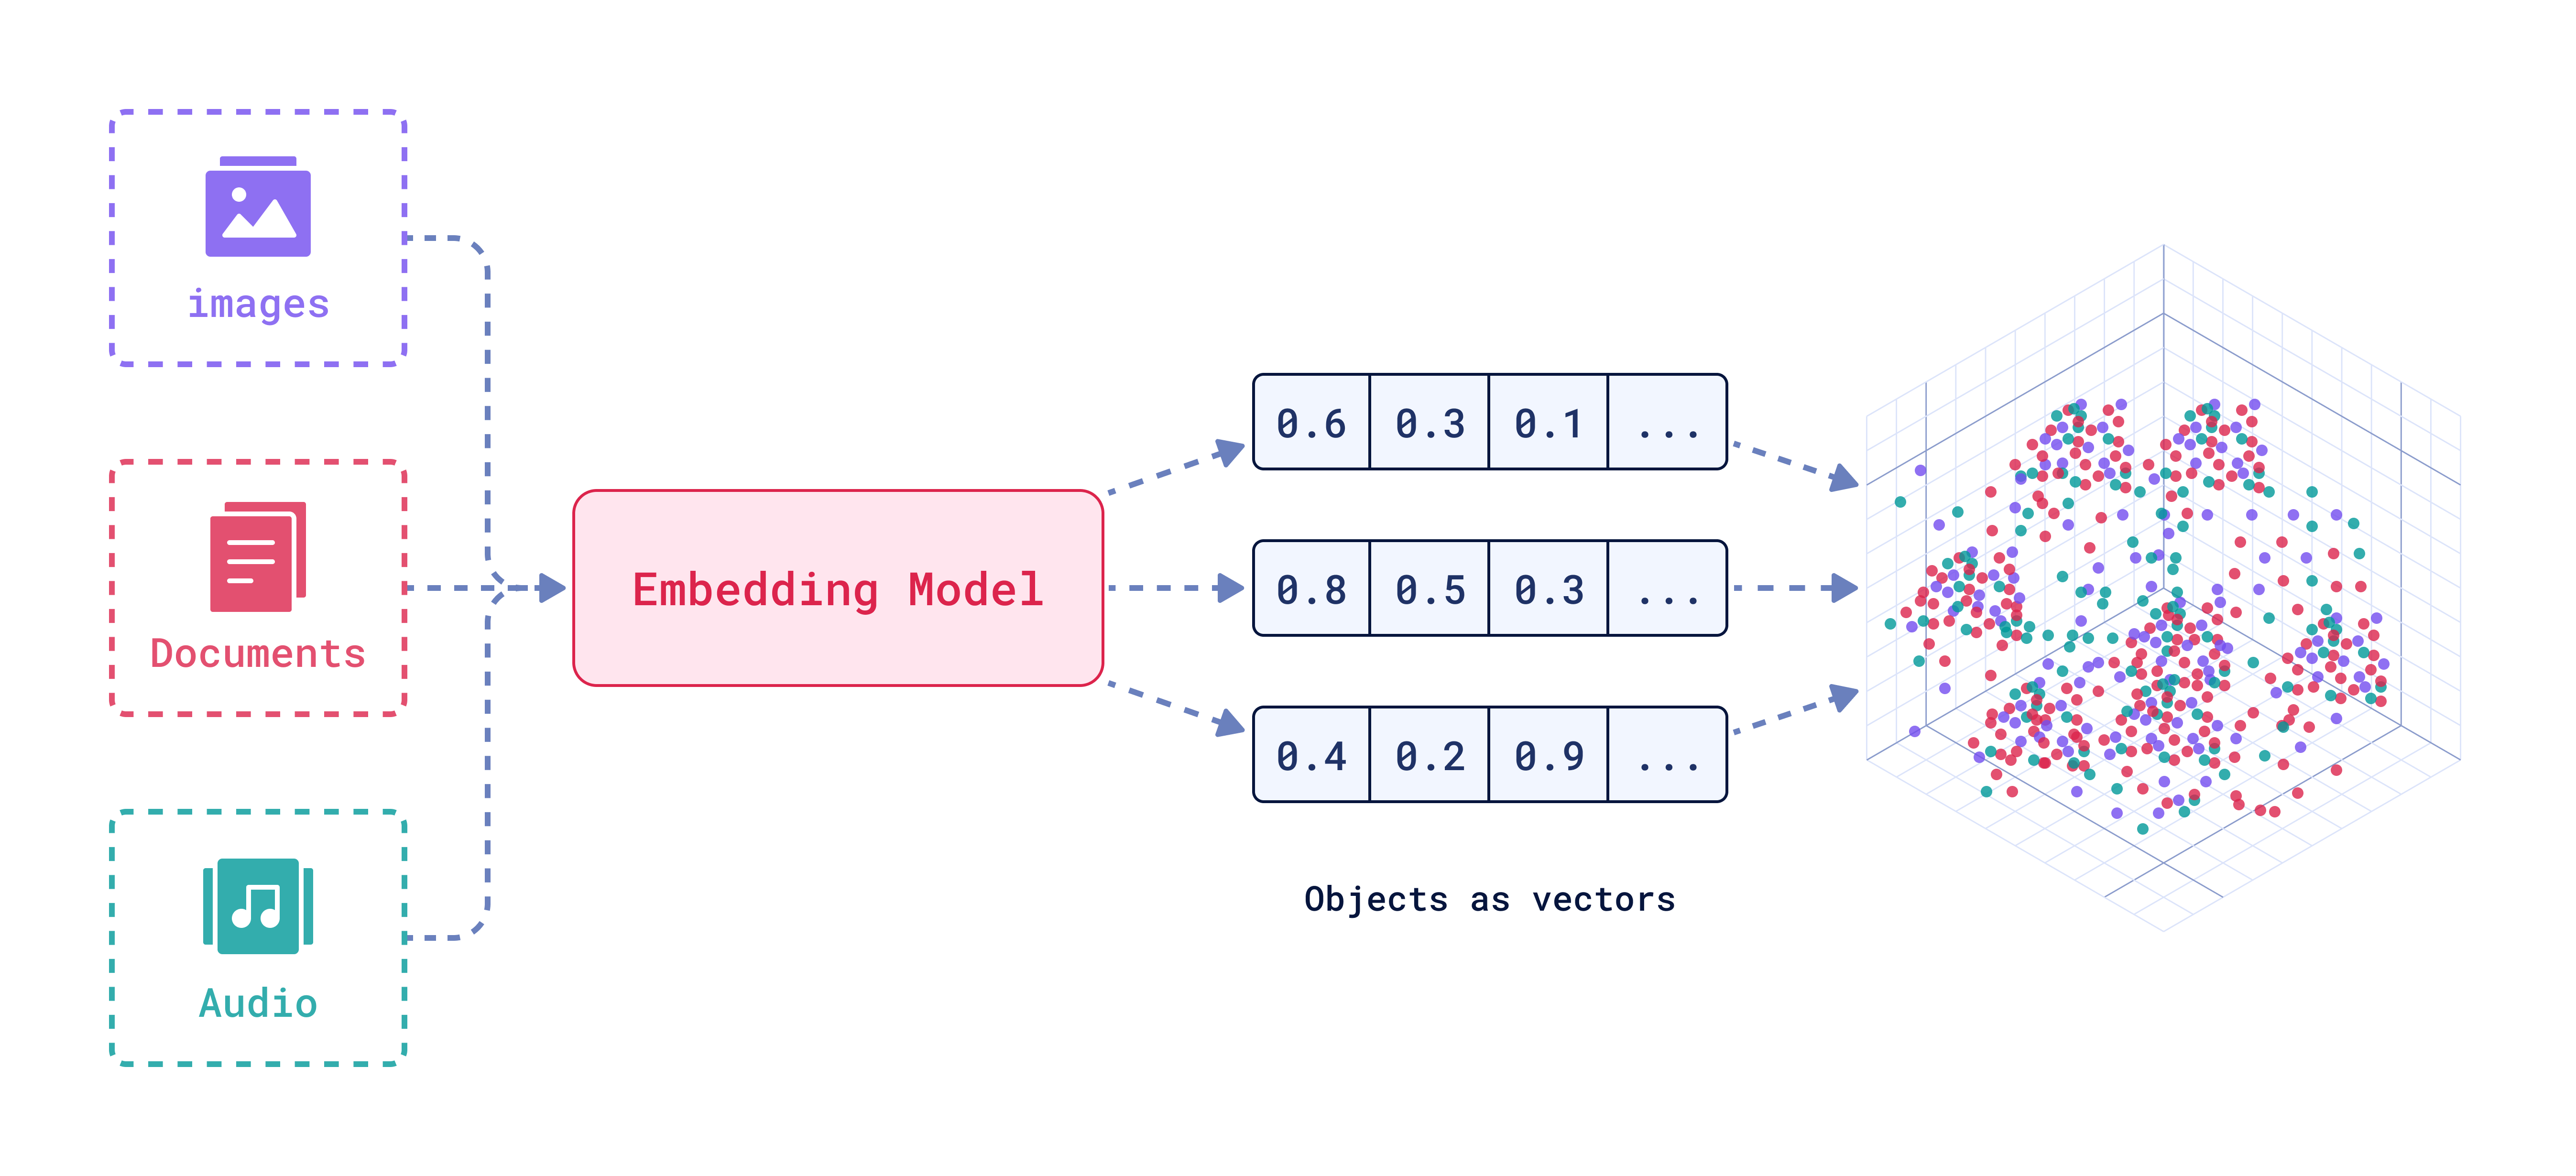

Un modello di embedding efficace e "generalizzato" può richiedere molto tempo e risorse per essere addestrato, quindi un modello pre-addestrato di OpenAI, per convertire le immagini in array di numeri

In [ ]:
from ice.animals import embed_animals_dataset

embeddings = embed_animals_dataset(files)

Scegliamo un'immagine a caso (numero 'n') e vediamo come è stata trasformata dal modello di embedding

In [ ]:
# Visualizzo prima immagine e sua rappresentazione embeddata

from PIL import Image
import matplotlib.pyplot as plt

n = 0

pic = Image.open(files[n])

print(f"Scelta immagine numero {n}")

print("Dimensione immagine:", pic.size)
print("Dimensione embedding:", embeddings[n].size)

plt.imshow(pic)
plt.axis("off")
plt.show()

print(f"Embedding immagine:")
print(embeddings[n])

Ora che abbiamo embeddato le nostre immagini, rappresentiamole in uno spazio 2D per vedere come si posizionano reciprocamente

Dal momento che a ogni immagine corrisponde un array di N dimensioni, dobbiamo ridurre la dimensione a 2D

Possiamo fare questa operazione con un modello di machine learning chiamato "**UMAP**", che riduce il numero di coordinate preservando il più possibile le relazioni spaziali tra i vari punti

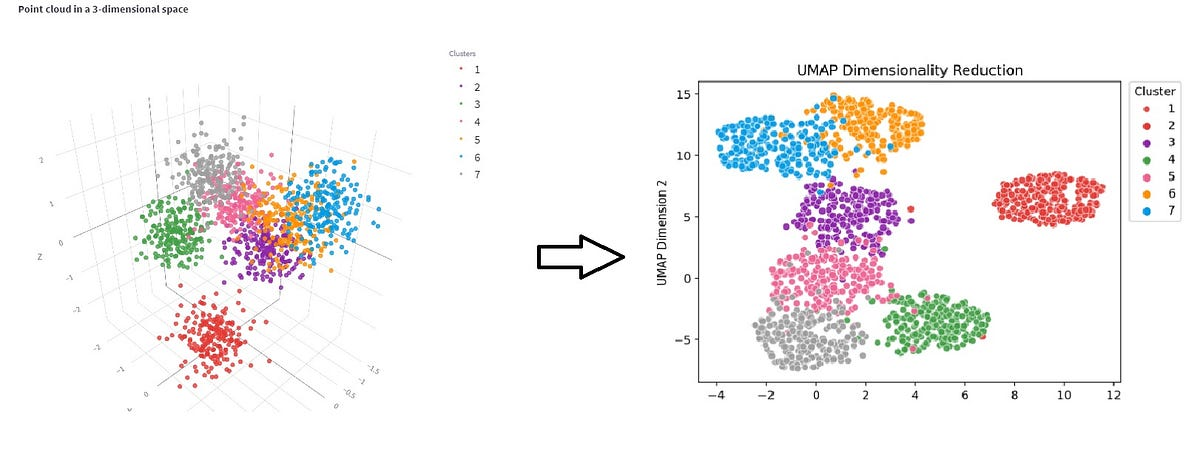

Come molti modelli di machine learning, UMAP utilizza degli "iperparametri", che permettono di regolare il modello, per migliorarne le performance

Nel caso di UMAP, i due iperparametri principali sono:
- **n_neighbors**: Regola la bilancia tra la conservazione delle strutture locali e globali. Un valore più basso enfatizza le strutture locali, mentre uno più alto enfatizza la struttura globale.
- **min_dist**: Controlla quanto i punti possono essere vicini nella proiezione finale, influenzando la densità dei cluster e la separazione dei gruppi.

Vediamo cosa succede se regoliamo questi due parametri. Cerchiamo di trovare dei valori che permettano di rendere le famiglie di animali ben distinte

Possiamo anche caricare delle foto nuove (salvare percorsi in 'my_pictures') e vedere dove si collocano rispetto alle altre immagini



In [ ]:
import ipywidgets

from ice.animals import update_UMAP

my_pictures = [
    "/content/newdog.jpg",
    "/content/newmouse.jpeg",
    "/content/newgiraffe.JPG",
]

n_slider = ipywidgets.IntSlider(
    value=10, min=1, max=20, step=1, description="Neighbors:", continuous_update=False
)
d_slider = ipywidgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=1.0,
    step=0.05,
    description="Min Dist:",
    continuous_update=False,
)

interactive_widget = ipywidgets.interactive(
    update_UMAP,
    n_slider=n_slider,
    d_slider=d_slider,
    my_pictures=my_pictures,
    embeddings=embeddings,
    labels=labels,
    names=names,
)

display(interactive_widget)

Una volta scelti n_neighbours e min_dist, applichiamo un altro modello di machine learning per fare un clustering delle immagini

Utilizziamo il modello **K-Means**, che identifica k gruppi di punti nello spazio

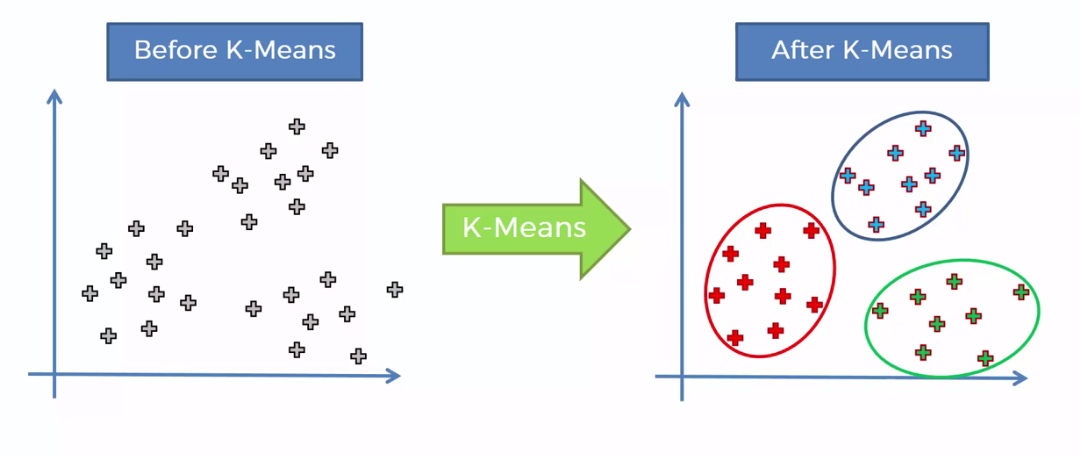

Vediamo cosa succede regolando l'iperparametro k, ovvero il numero di cluster che si vogliono identificare

In [ ]:
import umap

from ice.animals import update_KMeans

umap_reducer = umap.UMAP(
    n_neighbors=n_slider.value, min_dist=d_slider.value, n_components=2, random_state=42
)
embedding_2d = umap_reducer.fit_transform(embeddings)

k_slider = ipywidgets.IntSlider(
    value=3, min=1, max=15, step=1, description="Clusters:", continuous_update=False
)

interactive_widget = ipywidgets.interactive(
    update_KMeans,
    k_slider=k_slider
    my_pictures=my_pictures,
    umap_reducer=umap_reducer,
    embedding_2d=embedding_2d,
    labels=labels,
    names=names,
)

display(interactive_widget)

In alcuni casi, potrebbe risultare difficile far sì che alcuni animali siano chiaramente distinti. Questo può avvenire sia per animali simili (es. mouse-hamster), sia per animali molto diversi (es. giraffe-tiger)

Quale potrebbe essere il motivo?